# Processamento de linguagem natural - features clássicas

O projeto tem como objetivo criar um modelo de classificação para predição de sentimentos em avaliações de produtos da Amazon¹, a partir do uso de features clássicas de processamento de linguagem natural.

A fim de atingir esse objetivo, o relatório se divide nos seguintes tópicos:

1. Tratamento da base de dados
2. Análise exploratória dos dados
3. Modelos preditivos
    * Modelos com features clássicas
    * Bigrama com TF-IDF
4. Implementação do modelo
5. Referências

# 1. Tratamento da base de dados

A base de dados de avaliações originalmente é dividida em três arquivos diferentes: positivo, negativo e não-classificados. O nome do arquivo é referente ao sentimento atrelado às avaliações, portanto, os arquivos positivo e negativo foram combinados e foi criada uma coluna 'sentiment' preenchida de acordo com a classificação da avaliaçaõ. Já o arquivo unlabeled vai ser usado para implementação do modelo de classificação escolhido.

Os arquivos ainda foram tratados por meio de uma verificação de ids únicos (os ids eram únicos, portanto não foi necessário fazer nenhuma alteração nesse sentido) e avaliações de categorias de produto diferentes de eletrônicos foram excluídas da base.

In [78]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import textwrap as tw
import xml.etree.ElementTree as et
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn import tree
from sklearn.metrics import recall_score

In [3]:
def parse_XML(xml_file, df_cols):
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    
    for node in xroot:
        res = []
        res.append(node.attrib.get(df_cols[0]))
        for el in df_cols[1:]:
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else:
                res.append(None)
        rows.append({df_cols[i]: res[i]
                    for i, _ in enumerate(df_cols)})
    
    out_df = pd.DataFrame(rows, columns=df_cols)
    
    return out_df

In [5]:
df = parse_XML("negative.review", 
          [
              't', 'review', 'unique_id', 'asin', 'product_name', 'product_type',
              'helpful', 'rating', 'title', 'date', 'reviewer', 
              'reviewer_location', 'review_text'
          ])

In [11]:
df.replace(r'\n','', regex=True, inplace=True)
df['sentiment'] = 'negative'
df.drop(columns=['t', 'review'], inplace=True)
df.head()

In [19]:
p_df = parse_XML("positive.review", 
          [
              't', 'review', 'unique_id', 'asin', 'product_name', 'product_type',
              'helpful', 'rating', 'title', 'date', 'reviewer', 
              'reviewer_location', 'review_text'
          ])

In [21]:
p_df.replace(r'\n','', regex=True, inplace=True) 
p_df['sentiment'] = 'positive'
p_df.drop(columns=['t', 'review'], inplace=True)
p_df.head()

,unique_id,asin,product_name,product_type,helpful,rating,title,date,reviewer,reviewer_location,review_text,sentiment
0,"B00006HYUB:everyone_should_own_one:d._john_""lo...",B00006HYUB,APC Back-UPS ES 500 Backup Battery and Surge P...,electronics,3 of 3,5.0,Everyone should own one,"July 31, 2006","D. John ""Looser""",PA,I purchased this unit due to frequent blackout...,positive
1,B00006HYUB:breif_review:scott_park,B00006HYUB,APC Back-UPS ES 500 Backup Battery and Surge P...,electronics,11 of 12,5.0,Breif Review,"September 26, 2005",Scott Park,"New York, NY USA",I ordered 3 APC Back-UPS ES 500s on the recomm...,positive
2,"B00006HYUB:works_fine.:dee_richards_""deeanalyst""",B00006HYUB,APC Back-UPS ES 500 Backup Battery and Surge P...,electronics,0 of 2,4.0,Works fine.,"September 15, 2005","Dee Richards ""deeanalyst""","Mobile, AL",Wish the unit had a separate online/offline li...,positive
3,B000067VBM:affordable_and_effective:jason_dick...,B000067VBM,50-pack Slim CD/DVD Jewel Cases (5mm) Clear: E...,electronics,4 of 4,5.0,Affordable and effective,"July 7, 2005","Jason Dickson ""Needs More Money""","Maryville, TN USA",Cheaper than thick CD cases and less prone to ...,positive
4,B00008SCFU:it_is_a_good_product_:kiran_k._sing...,B00008SCFU,Kingston 256 MB Secure Digital Card ( SD/256 )...,electronics,,5.0,It is a good product,"February 24, 2006",Kiran K. Singarapu,,HiI brought 256 MB Kingston SD card from Amazo...,positive


In [25]:
df = pd.concat([df, p_df], ignore_index=True, sort=False)
df.shape

(2000, 12)

In [ ]:
# Deixando apenas com uma categoria
df.groupby('product_type')['product_type'].count()
df.drop(df.loc[(df['product_type'] == 'computer andamp; video games')].index, inplace=True)

# Verificando se os ids são realmente únicos
len(df['unique_id'].unique())

In [ ]:
unlabeled_df = parse_XML('unlabeled.review', 
          [
              't', 'review', 'unique_id', 'asin', 'product_name', 'product_type',
              'helpful', 'rating', 'title', 'date', 'reviewer', 
              'reviewer_location', 'review_text'
          ])
unlabeled_df.replace(r'\n','', regex=True, inplace=True) 
unlabeled_df.drop(columns=['t', 'review'], inplace=True)
unlabeled_df.head()

In [ ]:
# Deixando apenas com uma categoria
unlabeled_df.groupby('product_type')['product_type'].count()
unlabeled_df.drop(unlabeled_df.loc[(unlabeled_df['product_type'] == 'computer andamp; video games')].index, inplace=True)

# Verificando se os ids são realmente únicos
len(unlabeled_df['unique_id'].unique())

# 2. Análise exploratória dos dados

Com os dados devidamente tratados, primeiramente verifica-se se as classes estão desbalanceadas. Em caso de modelos de classificação, classes desbalanceadas podem levar à modelos que classifiquem melhor a classe sobrerepresentada. No caso, ambos os sentimentos positivos e negativos possuem aproximadamente o mesmo número de avaliações.

Uma análise mais detalhada dos produtos mostra que o maior número de avaliações por produto é 5, ou seja, os produtos não possuem um alto número de avaliações.

Por fim, verifica-se a distribuição do número de palavras por título e texto das avaliações. Como era de se esperar, a variável de título possui uma menor média (26 palavras) que a variável de texto (594 palavras).
O histograma do texto das avaliações mostra que 75% das avaliações tem até 720 palavras.

In [147]:
# Verificando se classes estão balanceadas
df.groupby('sentiment')['unique_id'].count()

sentiment
negative     999
positive    1000
Name: unique_id, dtype: int64

In [41]:
df['product_name'].value_counts()

Memorex DVD+R 16x 4.7GB 50 Pack Spindle: Electronics                      5
Xtreme TB264DKO 264-Disc CD/DVD Case: Electronics                         5
Philips HN060/37 Noise-Canceling Earbuds: Electronics                     5
Belkin TuneCast II FM Transmitter: Electronics                            5
Altec Lansing FX6021 3-Piece System: Electronics                          4
                                                                         ..
Case Logic DMB-5 CD Sports Pack: Electronics                              1
SanDisk SDDR-80-784 Firewire CF Reader: Electronics                       1
HP Photosmart 385 Compact Photo Printer (Q6387A#ABA): Electronics         1
SimpleTech SimpleDrive 250 GB External USB 2.0 Hard Drive: Electronics    1
Altec Lansing inMotion Portable Audio System for iPod: Electronics        1
Name: product_name, Length: 1297, dtype: int64

In [43]:
df['title_len'] = df['title'].apply(lambda x: len(x))
df['review_len'] = df['review_text'].apply(lambda x: len(x))

In [149]:
print('Média dos títulos: ', df['title_len'].mean())
print('Média dos textos: ', df['review_len'].mean())

Média dos títulos:  25.692846423211606
Média dos textos:  593.9614807403702


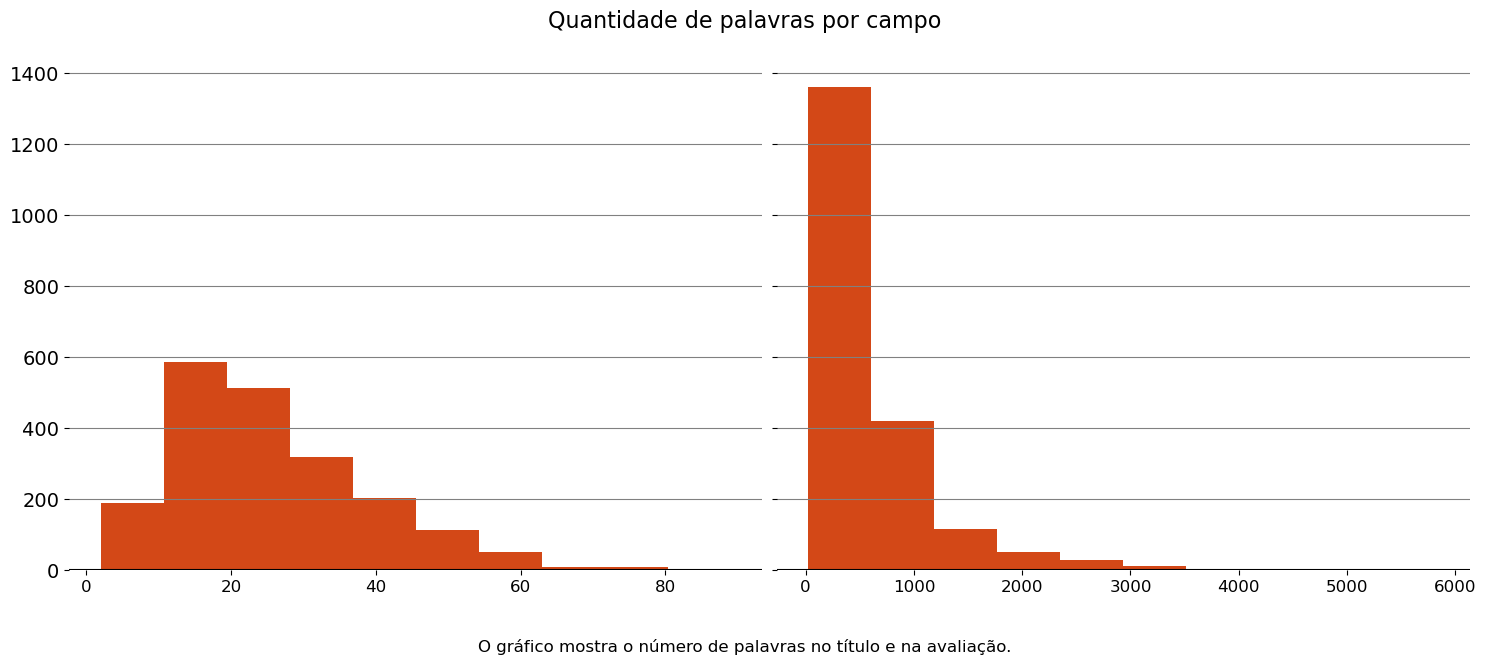

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), sharey=True)

ax1.hist(df['title_len'], color='#D34817')
ax2.hist(df['review_len'], color='#D34817')

for ax in ax1, ax2:
    ax.axhline(0, c="black")
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=14)
    ax.yaxis.grid(True, color='gray', zorder=1)
    ax.xaxis.grid(False)
    ax.set_facecolor('white')
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False

fig.suptitle(f"Quantidade de palavras por campo", y=1, fontsize=16)
footnote = f"O gráfico mostra o número de palavras no título e na avaliação."

fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)
plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")
plt.box(False)
plt.tight_layout()
    
plt.show()

# 3. Modelos preditivos

Esse tópico se destina a criar modelos de classificação com as três features clássicas de processamento de linguagem natural:

1. Contagem de palavras: conta a quantidade de cada palavra em uma observação. Essa métrica tende a ser enviesada, porque palavras com maior número de caracteres tendem a ser mais importantes. A métrica abaixo pode solucionar esse problema.
2. Frequência de termos: conta a frequência com que a palavra aparece na observação. Essa métrica pode ser enviesada, pois palavras-chave tendem a aparecer com menos frequência que artigos e preposições. 
3. Frequência do termo–inverso da frequência nos documentos (TD-IDF): Tende a resolver as desvantagens das métricas acima, pois entende que palavras-chave não aparecem tanto.


# 3.1 Modelos com features clássicas

Os modelos de classificação gerados são:

1. Support vector machine
2. Árvore de decisão

Para cada modelo, foram testadas as três métricas acima, a fim de selecionar o modelo de melhor performance.
A métrica de avaliação dos modelos usada foi o recall, pois permite verificar a porcentagem de valores positivos que foram preditos corretamente. Assim, garante-se que o modelo é capaz de acertar as avaliações positivas e, portanto, as negativas também.

O modelo que apresentou melhor performance foi o support vector machine com bigramas, ao apresentar um recall de 88%.

In [57]:
df['full_text'] = (df['title'] + " " + df['review_text']).str.lower()
le = LabelEncoder()
X = df['full_text']
y = le.fit_transform(df['sentiment'])

In [88]:
# CREATING WORD COUNT WITH UNIGRAM
count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(X)

# CREATING WORD COUNT WITH BIGRAM
count_vec_ngram = CountVectorizer(ngram_range=(2, 2))
X_counts_bigram = count_vec_ngram.fit_transform(X)

# CREATING WORD FREQUENCY
tf = TfidfTransformer(use_idf=False, norm="l1")
X_freq = tf.fit_transform(X_counts)

# CREATING TF-IDF
tf = TfidfTransformer(norm="l1")
X_tfidf = tf.fit_transform(X_counts)

# BIGRAMA COM WORD FREQUENCY E TF-IDF
X_freq_bigram = tf.fit_transform(X_counts_bigram)
X_tfidf_bigram = tf.fit_transform(X_counts_bigram)

# SEPARAÇÃO EM TREINO E TESTE
X_train_counts, X_test_counts, y_train_counts, y_test_counts = train_test_split(X_counts, y, test_size=.2)
X_train_bigram, X_test_bigram, y_train_bigram, y_test_bigram = train_test_split(X_counts_bigram, y, test_size=.2)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y, test_size=.2)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=.2)
X_train_freq_bigram, X_test_freq_bigram, y_train_freq_bigram, y_test_freq_bigram = train_test_split(X_freq_bigram, y, test_size=.2)
X_train_tfidf_bigram, X_test_tfidf_bigram, y_train_tfidf_bigram, y_test_tfidf_bigram = train_test_split(X_tfidf_bigram, y, test_size=.2)

In [104]:
# SVM - COMO RESOLVER ESSE WARNING?

param_grid = [
  {'C': [1, 10, 100, 1000]}
 ]

svc = LinearSVC()
svm_counts = GridSearchCV(svc, param_grid).fit(X_train_counts, y_train_counts)
svm_bigram = GridSearchCV(svc, param_grid).fit(X_train_bigram, y_train_bigram)
svm_freq = GridSearchCV(svc, param_grid).fit(X_train_freq, y_train_freq)
svm_tfidf = GridSearchCV(svc, param_grid).fit(X_train_tfidf, y_train_tfidf)

svm_y_pred_counts = svm_counts.predict(X_test_counts)
svm_y_pred_bigram = svm_bigram.predict(X_test_bigram)
svm_y_pred_freq = svm_freq.predict(X_test_freq)
svm_y_pred_tfidf = svm_tfidf.predict(X_test_tfidf)

C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the numbe

C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the numbe

In [105]:
svm_rec_counts = recall_score(y_test_counts, svm_y_pred_counts)
svm_rec_bigram = recall_score(y_test_bigram, svm_y_pred_bigram)
svm_rec_freq = recall_score(y_test_freq, svm_y_pred_freq)
svm_rec_tfidf = recall_score(y_test_tfidf, svm_y_pred_tfidf)

print("Métricas usando SVM")
print("Recall de counts = {}".format(svm_rec_counts))
print("Recall de bigram = {}".format(svm_rec_bigram))
print("Recall de freq = {}".format(svm_rec_freq))
print("Recall de tfidf = {}".format(svm_rec_tfidf))

Métricas usando SVM
Recall de counts = 0.8571428571428571
Recall de bigram = 0.8863636363636364
Recall de freq = 0.8446601941747572
Recall de tfidf = 0.8563829787234043


In [101]:
# ÁRVORE DE DECISÃO - POR QUE BIGRAMA NÃO FUNCIONA?

tree = tree
tree_counts = tree.fit(X_train_counts, y_train_counts)
tree_freq = tree.fit(X_train_freq, y_train_freq)
tree_tfidf = tree.fit(X_train_tfidf, y_train_tfidf)

tree_y_pred_counts = tree_counts.predict(X_test_counts)
tree_y_pred_freq = tree_freq.predict(X_test_freq)
tree_y_pred_tfidf = tree_tfidf.predict(X_test_tfidf)

tree_rec_counts = recall_score(y_test_counts, tree_y_pred_counts)
tree_rec_freq = recall_score(y_test_freq, tree_y_pred_freq)
tree_rec_tfidf = recall_score(y_test_tfidf, tree_y_pred_tfidf)

print("Métricas usando árvore de decisão")
print("Recall de counts = {}".format(tree_rec_counts))
print("Recall de freq = {}".format(tree_rec_freq))
print("Recall de tfidf = {}".format(tree_rec_tfidf))

Métricas usando árvore de decisão
Recall de counts = 0.8226600985221675
Recall de freq = 0.7524271844660194
Recall de tfidf = 0.6702127659574468


In [99]:
tree_counts_bigram = tree.fit(X_train_bigram, y_train_bigram)
tree_y_pred_bigram = tree_counts_bigram.predict(X_test_bigram)
tree_rec_counts_bigram = recall_score(y_test_bigram, tree_y_pred_bigram)
print("Recall de bigram = {}".format(tree_rec_counts_bigram))

Recall de bigram = 0.8318181818181818


# 3.2 Bigrama com TF-IDF

Como os modelos rodados com bigramas apresentaram melhor performance que os modelos criados com unigramas, roda-se os modelos com bigramas e TF-IDF, pois essa métrica tende a corrigir problemas inerentes a contagem de palavras. Porém, o modelo rodado claramente apresente overfitting, já que o recall é de 1.0.

In [103]:
# BIGRAMA COM TFIDF
svm_tfidf_bigram = GridSearchCV(svc, param_grid).fit(X_train_tfidf_bigram, y_train_tfidf_bigram)
tree_tfidf_bigram = tree.fit(X_train_tfidf_bigram, y_train_tfidf_bigram)

svm_y_pred_tfidf_bigram = svm_tfidf_bigram.predict(X_test_tfidf_bigram)
tree_y_pred_tfidf_bigram = tree_tfidf_bigram.predict(X_test_tfidf_bigram)

svm_rec_tfidf_bigram = recall_score(y_test_tfidf_bigram, svm_y_pred_tfidf_bigram)
tree_rec_tfidf_bigram = recall_score(y_test_tfidf_bigram, tree_y_pred_tfidf_bigram)

print("Recall de svm tfidf bigrama = {}".format(svm_rec_tfidf_bigram))
print("Recall de tree tfidf bigrama = {}".format(tree_rec_tfidf_bigram))

C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the numbe

Recall de svm tfidf bigrama = 0.8291457286432161
Recall de tree tfidf bigrama = 0.7537688442211056


# 4. Implementação do modelo

Este tópico se destina à implementação do modelo com melhor performance para previsão do sentimento em avaliações ainda não classificadas da categoria eletrônicos.

Para isso, roda-se o modelo de classificação que apresentou melhor performance: support vector machine com bigramas.

In [142]:
unlabeled_df['full_text'] = (unlabeled_df['title'] + " " + unlabeled_df['review_text']).str.lower()
unlabeled_X = unlabeled_df['full_text']
unlabeled_X_bigram = count_vec_ngram.fit_transform(unlabeled_X)

In [146]:
svm_y_pred_bigram = svm_bigram.predict(unlabeled_X_bigram)

ValueError: X has 391033 features per sample; expecting 99694

# 5. Referências

1. https://www.cs.jhu.edu/~mdredze/datasets/sentiment/index2.html

A few notes regarding the data.


1) There are 4 directories corresponding to each of the four domains. Each directory contains 3 files called positive.review, negative.review and unlabeled.review. (The books directory doesn't contain the unlabeled but the link is below.) While the positive and negative files contain positive and negative reviews, these aren't necessarily the splits we used in the experiments. We randomly drew from the three files ignoring the file names.


2) Each file contains a pseudo XML scheme for encoding the reviews. Most of the fields are self explanatory. The reviews have a unique ID field that isn't very unique. If it has two unique id fields, ignore the one containing only a number.


There are always small details and I am sure that I omitted many of them. If you have a question after reading the paper and this page, please let me know.

2. https://medium.com/tableless/classificando-o-conteudo-do-stack-exchange-8f3ea68fb2af
3. https://medium.com/tableless/classificando-o-conteudo-do-stack-exchange-02-6d9975e00ff7
4. https://medium.com/tableless/classificando-o-conteudo-do-stack-exchange-2ad62aba0638